Import the datasets the cleaned dataset

In [ ]:
!pwd
!ls

from google.colab import drive
drive.mount('/content/drive')
%cd ..
%cd /content/drive/MyDrive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# The dataset cleaned and exported to CSV in Assignment 1 was too clean to be used for logistic regression and K-means analysis.
# I used the sub-dataset that was cleaned in Assignment 1 but not exported to CSV at the beginning of Assignment 2.

cars = pd.read_csv("Electric_Vehicle_Population_Size_History_By_County_.csv")
cars["Date"] = pd.to_datetime(cars["Date"])
cars["State"] = cars["State"].astype("string")
cars["County"] = cars["County"].astype("string")
cars["Non-Electric Vehicle Total"] = cars["Non-Electric Vehicle Total"].str.replace(',', '').astype("int32")
cars["Total Vehicles"] = cars["Total Vehicles"].str.replace(',', '').astype("int32")
cars = cars.drop(columns=["Vehicle Primary Use"])
cars = cars.drop(columns=["Battery Electric Vehicles (BEVs)"])
cars = cars.drop(columns=["Plug-In Hybrid Electric Vehicles (PHEVs)"])
cars = cars.drop(columns=["Electric Vehicle (EV) Total"])

cars_list = [None]*5
cars_list_KMeans = [None]*5
for i in range(0,5):
  cars_list[i] = cars[cars["Date"].dt.year == i+2017]
  cars_list[i].reset_index(inplace=True)
  cars_list_KMeans[i] = cars_list[i].copy(deep=True)
for i in range(len(cars_list)):
  cars_list[i] = cars_list[i].sort_values(by=["State", "County", "Date"], ascending=[True, True, False])
  cars_list[i] = cars_list[i].drop_duplicates(subset=["State","County"], keep='first')
  cars_list[i] = cars_list[i].sort_values(by=["State","County"])
  cars_list_KMeans[i] = cars_list_KMeans[i].sort_values(by=["County", "Date"], ascending=[True, False])
  cars_list_KMeans[i] = cars_list_KMeans[i].drop_duplicates(subset=["County"], keep='first')
  cars_list_KMeans[i] = cars_list_KMeans[i].sort_values(by=["County"], ascending=[True])
  cars_list_KMeans[i].reset_index(inplace=True)
  cars_list_KMeans[i] = cars_list_KMeans[i][cars_list_KMeans[i]["State"] == "WA"]

state_sums_list = [None]*5
for i in range(len(cars_list)):
  state_sums_list[i] = (cars_list[i].drop(columns=["Date","index","County"])).groupby('State').sum().reset_index()
  state_sums_list[i]['Percent Electric Vehicles'] = (1 - (state_sums_list[i]['Non-Electric Vehicle Total'] / state_sums_list[i]['Total Vehicles']))*100
common_states = state_sums_list[0]['State']
for df in state_sums_list[1:]:
  common_states = common_states[common_states.isin(df['State'])]
filtered_state_sums_list = [df[df['State'].isin(common_states)] for df in state_sums_list]

emissions = pd.read_csv("emissions.csv")
emissions["state-name"] = emissions["state-name"].astype("string")
emissions["sector-name"] = emissions["sector-name"].astype("string")
emissions["fuel-name"] = emissions["fuel-name"].astype("string")

emissions = emissions[emissions["fuel-name"] == "All Fuels"]
emissions = emissions[emissions["sector-name"] == "Transportation carbon dioxide emissions"]

emissions_backup = emissions.copy(deep=True)

emissions = emissions[emissions["year"] >= 2017]
emissions = emissions[emissions["year"] <= 2021]
emissions.reset_index(inplace=True)

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

emissions['state-name'] = emissions['state-name'].map(state_abbrev)
emissions = emissions.rename(columns={'state-name': 'State'})
emissions = emissions.rename(columns={'value': 'Carbon Dioxide Emissions From Transportation'})

filtered_emissions = emissions[emissions['State'].isin(common_states)]

for df in filtered_state_sums_list:
  df = df.assign(year=2017)

for i in range(len(filtered_state_sums_list)):
  filtered_state_sums_list[i] = filtered_state_sums_list[i].assign(year=2017+i)

combined_filtered_state_sums = pd.concat(filtered_state_sums_list, ignore_index=True)
merged_all_state_percent_emission = pd.merge(combined_filtered_state_sums, filtered_emissions, on=['State', 'year'])

/content
sample_data
Mounted at /content/drive
/
/content/drive/MyDrive


In [ ]:
merged_all_state_percent_emission.head(2000)

,State,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,year,index,sector-name,fuel-name,Carbon Dioxide Emissions From Transportation
0,AK,46,47,2.127660,2017,54511,Transportation carbon dioxide emissions,All Fuels,11.233929
1,AZ,2398,2406,0.332502,2017,54540,Transportation carbon dioxide emissions,All Fuels,36.870866
2,CA,7736,7776,0.514403,2017,54578,Transportation carbon dioxide emissions,All Fuels,208.002702
3,CO,777,780,0.384615,2017,54597,Transportation carbon dioxide emissions,All Fuels,29.494230
4,CT,299,301,0.664452,2017,54623,Transportation carbon dioxide emissions,All Fuels,15.414134
...,...,...,...,...,...,...,...,...,...
165,SC,380,388,2.061856,2021,59662,Transportation carbon dioxide emissions,All Fuels,32.613895
166,TN,220,223,1.345291,2021,59704,Transportation carbon dioxide emissions,All Fuels,45.725218
167,TX,2096,2126,1.411101,2021,59723,Transportation carbon dioxide emissions,All Fuels,215.203405
168,VA,3121,3169,1.514673,2021,59805,Transportation carbon dioxide emissions,All Fuels,49.771732


In [ ]:
merged_all_state_percent_emission['Weighted Electric Vehicles'] = merged_all_state_percent_emission['Total Vehicles'] * merged_all_state_percent_emission['Percent Electric Vehicles']
total_weighted_ev = merged_all_state_percent_emission['Weighted Electric Vehicles'].sum()
merged_all_state_percent_emission['Weighted Percent Electric Vehicles'] = merged_all_state_percent_emission['Weighted Electric Vehicles'] / total_weighted_ev * 100
merged_all_state_percent_emission = merged_all_state_percent_emission[merged_all_state_percent_emission['State'] != 'WA']

In [ ]:
merged_all_state_percent_emission.head(2000)

,State,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,year,index,sector-name,fuel-name,Carbon Dioxide Emissions From Transportation,Weighted Electric Vehicles,Weighted Percent Electric Vehicles
0,AK,46,47,2.127660,2017,54511,Transportation carbon dioxide emissions,All Fuels,11.233929,100.0,0.000636
1,AZ,2398,2406,0.332502,2017,54540,Transportation carbon dioxide emissions,All Fuels,36.870866,800.0,0.005084
2,CA,7736,7776,0.514403,2017,54578,Transportation carbon dioxide emissions,All Fuels,208.002702,4000.0,0.025420
3,CO,777,780,0.384615,2017,54597,Transportation carbon dioxide emissions,All Fuels,29.494230,300.0,0.001907
4,CT,299,301,0.664452,2017,54623,Transportation carbon dioxide emissions,All Fuels,15.414134,200.0,0.001271
...,...,...,...,...,...,...,...,...,...,...,...
164,PA,151,158,4.430380,2021,59618,Transportation carbon dioxide emissions,All Fuels,55.979143,700.0,0.004449
165,SC,380,388,2.061856,2021,59662,Transportation carbon dioxide emissions,All Fuels,32.613895,800.0,0.005084
166,TN,220,223,1.345291,2021,59704,Transportation carbon dioxide emissions,All Fuels,45.725218,300.0,0.001907
167,TX,2096,2126,1.411101,2021,59723,Transportation carbon dioxide emissions,All Fuels,215.203405,3000.0,0.019065


<Axes: xlabel='Weighted Percent Electric Vehicles', ylabel='Carbon Dioxide Emissions From Transportation'>

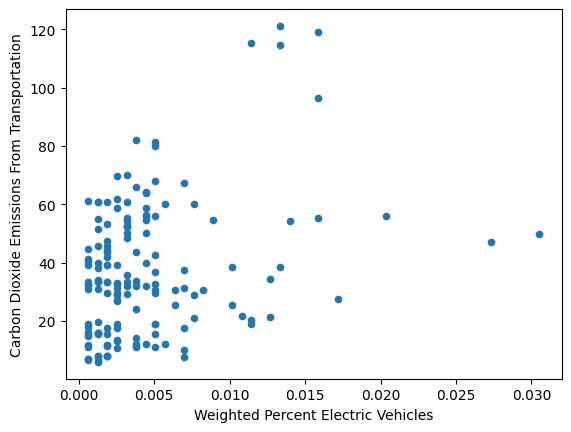

In [ ]:
merged_all_state_percent_emission_3_w = merged_all_state_percent_emission[(np.abs(stats.zscore(merged_all_state_percent_emission[["Weighted Percent Electric Vehicles","Carbon Dioxide Emissions From Transportation"]])) < 3).all(axis=1)]
merged_all_state_percent_emission_3_w.plot.scatter(x="Weighted Percent Electric Vehicles", y="Carbon Dioxide Emissions From Transportation")

Demo Linear Regression To verify the accuracy of the scratch code

Linear Regression Weighted Percent Electric Vehicles/Carbon Dioxide Emissions From Transportation (low score due to inaccurate data in the model itself)

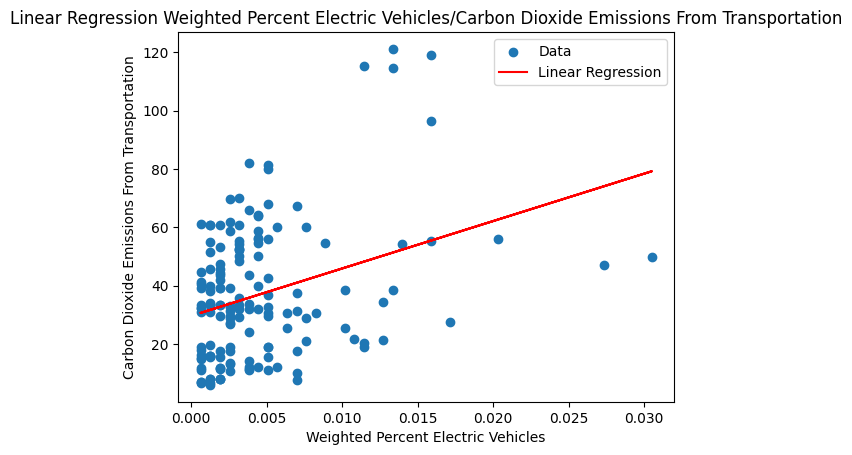

0.11197233428890219

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

x = merged_all_state_percent_emission_3_w["Weighted Percent Electric Vehicles"].values.reshape(-1,1)
y = merged_all_state_percent_emission_3_w["Carbon Dioxide Emissions From Transportation"].values.reshape(-1,1)

linear_model = LinearRegression()
linear_model.fit(x,y)

plt.scatter(x, y, label='Data')
plt.plot(x, linear_model.predict(x), color='red', label='Linear Regression')

plt.xlabel('Weighted Percent Electric Vehicles')
plt.ylabel('Carbon Dioxide Emissions From Transportation')
plt.title('Linear Regression Weighted Percent Electric Vehicles/Carbon Dioxide Emissions From Transportation')
plt.legend()
plt.show()

linear_model.score(x,y)

The linear regression chart obtained by correcting the core results of Assignment 1

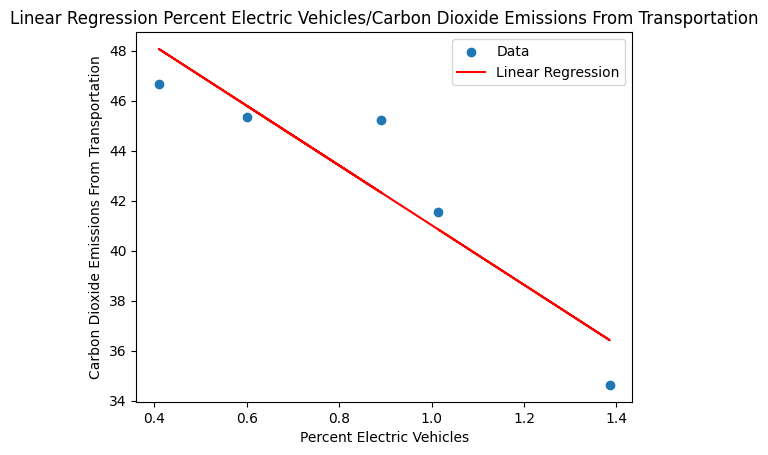

0.8507297804241711

In [ ]:
core_cleaned_assignment_1 = pd.read_csv("core_cleaned_processd.csv")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

x = core_cleaned_assignment_1["Percent Electric Vehicles"].values.reshape(-1,1)
y = core_cleaned_assignment_1["Carbon Dioxide Emissions From Transportation"].values.reshape(-1,1)

linear_model = LinearRegression()
linear_model.fit(x,y)

plt.scatter(x, y, label='Data')
plt.plot(x, linear_model.predict(x), color='red', label='Linear Regression')

plt.xlabel('Percent Electric Vehicles')
plt.ylabel('Carbon Dioxide Emissions From Transportation')
plt.title('Linear Regression Percent Electric Vehicles/Carbon Dioxide Emissions From Transportation')
plt.legend()
plt.show()

linear_model.score(x,y)

Scratch code of linear regression

R^2: 0.11197233428890219
p-value: 2.0845722570550507e-05


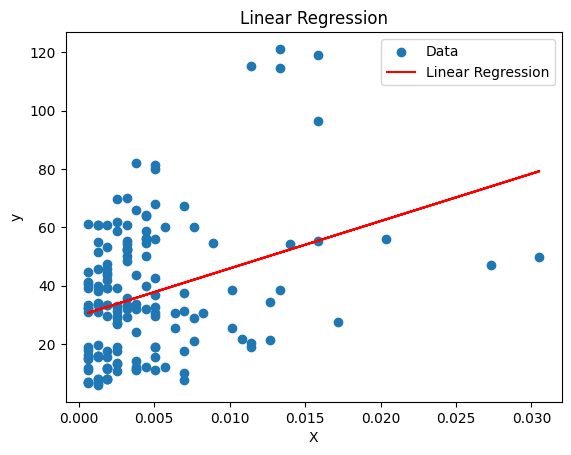

In [ ]:
import numpy as np
from scipy import stats

# use statst.t.cdf to calculate cumulative distribution

x = merged_all_state_percent_emission_3_w["Weighted Percent Electric Vehicles"].values.reshape(-1,1)
y = merged_all_state_percent_emission_3_w["Carbon Dioxide Emissions From Transportation"].values.reshape(-1,1)

np_x = np.array(x)
np_y = np.array(y)
mean_x = np.mean(x)
mean_y = np.mean(y)
coefficients = (np.sum((np_x-mean_x)*(np_y-mean_y)))/(np.sum((np_x-mean_x)**2))
intercept = mean_y - coefficients * mean_x
predict = intercept + coefficients * np_x

sum_squares_total = np.sum((np_y - mean_y) ** 2)
sum_squares_reg = np.sum((np_y - predict) ** 2)
r_squared = 1 - (sum_squares_reg / sum_squares_total)
t_statistics = coefficients / (np.sqrt(np.sum((np_y - predict) ** 2) / (np_x.shape[0] - 2)) / np.sqrt(np.sum((np_x - mean_x) ** 2)))
p_value = 2 * (1-stats.t.cdf(np.abs(t_statistics),df=np_x.shape[0]-2))

print(f"R^2: {r_squared}")
print(f"p-value: {p_value}")

plt.scatter(x, y, label='Data')
plt.plot(x, predict, color='red', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()

R^2: 0.8507297804241709
p-value: 0.02566969551018561


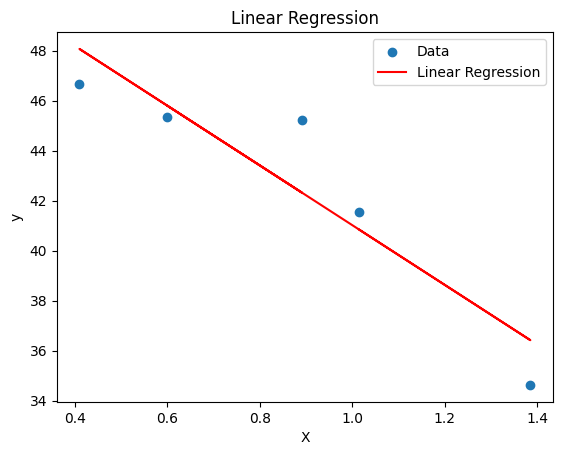

In [ ]:
import numpy as np
from scipy import stats

# use statst.t.cdf to calculate cumulative distribution
x = core_cleaned_assignment_1["Percent Electric Vehicles"].values.reshape(-1,1)
y = core_cleaned_assignment_1["Carbon Dioxide Emissions From Transportation"].values.reshape(-1,1)

np_x = np.array(x)
np_y = np.array(y)
mean_x = np.mean(x)
mean_y = np.mean(y)
coefficients = (np.sum((np_x-mean_x)*(np_y-mean_y)))/(np.sum((np_x-mean_x)**2))
intercept = mean_y - coefficients * mean_x
predict = intercept + coefficients * np_x

sum_squares_total = np.sum((np_y - mean_y) ** 2)
sum_squares_reg = np.sum((np_y - predict) ** 2)
r_squared = 1 - (sum_squares_reg / sum_squares_total)
t_statistics = coefficients / (np.sqrt(np.sum((np_y - predict) ** 2) / (np_x.shape[0] - 2)) / np.sqrt(np.sum((np_x - mean_x) ** 2)))
p_value = 2 * (1-stats.t.cdf(np.abs(t_statistics),df=np_x.shape[0]-2))

print(f"R^2: {r_squared}")
print(f"p-value: {p_value}")

plt.scatter(x, y, label='Data')
plt.plot(x, predict, color='red', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()

In [ ]:
emissions_linear_test = emissions_backup[(emissions_backup['state-name'] == "California")]
#emissions_backup = emissions_backup[(emissions_backup['state-name'] == "New York") | (emissions_backup['state-name'] == "Illinois") | (emissions_backup['state-name'] == "Pennsylania")]
emissions_linear_test = emissions_linear_test[emissions_linear_test["year"] >= 1985]
emissions_linear_test = emissions_linear_test[emissions_linear_test["year"] <= 2005]
emissions_linear_test_3std = \
emissions_linear_test \
[(np.abs(stats.zscore(emissions_linear_test[["value"]])) < 3).all(axis=1)]
emissions_linear_test.head(200)

,year,state-name,sector-name,fuel-name,value
17766,1985,California,Transportation carbon dioxide emissions,All Fuels,168.923855
18943,1986,California,Transportation carbon dioxide emissions,All Fuels,174.792968
20096,1987,California,Transportation carbon dioxide emissions,All Fuels,184.004961
21275,1988,California,Transportation carbon dioxide emissions,All Fuels,194.718415
22444,1989,California,Transportation carbon dioxide emissions,All Fuels,200.968093
23621,1990,California,Transportation carbon dioxide emissions,All Fuels,202.203899
24798,1991,California,Transportation carbon dioxide emissions,All Fuels,191.537666
25980,1992,California,Transportation carbon dioxide emissions,All Fuels,191.091113
27156,1993,California,Transportation carbon dioxide emissions,All Fuels,187.253162
28334,1994,California,Transportation carbon dioxide emissions,All Fuels,195.895106


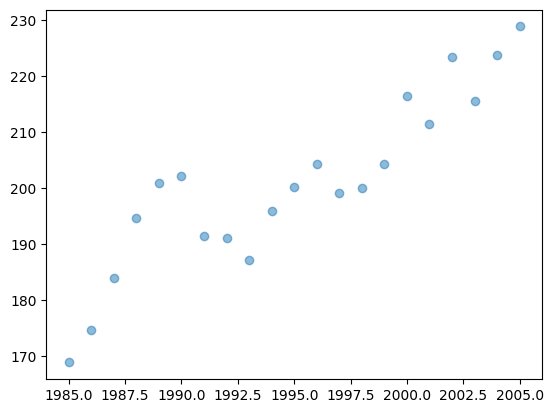

In [ ]:
plt.scatter(emissions_linear_test_3std["year"], emissions_linear_test_3std["value"], alpha=0.5)

R^2: 0.8116657917978035
p-value: 2.5662882485733007e-08


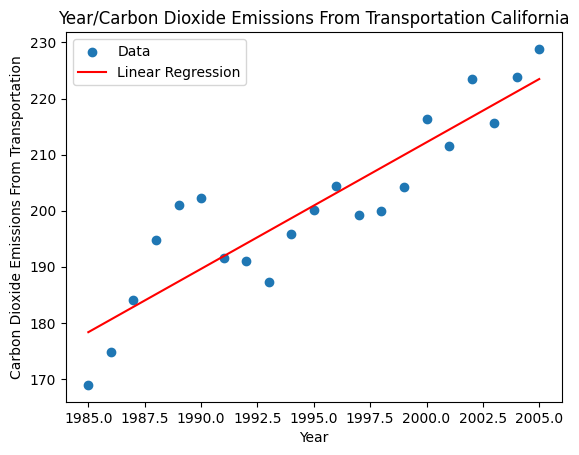

In [ ]:
import numpy as np
from scipy import stats

# use statst.t.cdf to calculate cumulative distribution
x = emissions_linear_test_3std["year"].values.reshape(-1,1)
y = emissions_linear_test_3std["value"].values.reshape(-1,1)

np_x = np.array(x)
np_y = np.array(y)
mean_x = np.mean(x)
mean_y = np.mean(y)
coefficients = (np.sum((np_x-mean_x)*(np_y-mean_y)))/(np.sum((np_x-mean_x)**2))
intercept = mean_y - coefficients * mean_x
predict = intercept + coefficients * np_x

sum_squares_total = np.sum((np_y - mean_y) ** 2)
sum_squares_reg = np.sum((np_y - predict) ** 2)
r_squared = 1 - (sum_squares_reg / sum_squares_total)
t_statistics = coefficients / (np.sqrt(np.sum((np_y - predict) ** 2) / (np_x.shape[0] - 2)) / np.sqrt(np.sum((np_x - mean_x) ** 2)))
p_value = 2 * (1-stats.t.cdf(np.abs(t_statistics),df=np_x.shape[0]-2))

print(f"R^2: {r_squared}")
print(f"p-value: {p_value}")

plt.scatter(x, y, label='Data')
plt.plot(x, predict, color='red', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('Carbon Dioxide Emissions From Transportation')
plt.title('Year/Carbon Dioxide Emissions From Transportation California')
plt.legend()
plt.show()

Demo KMeans To verify the accuracy of the scratch code

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'Scaled Percent Electric Vehicles Proportion')

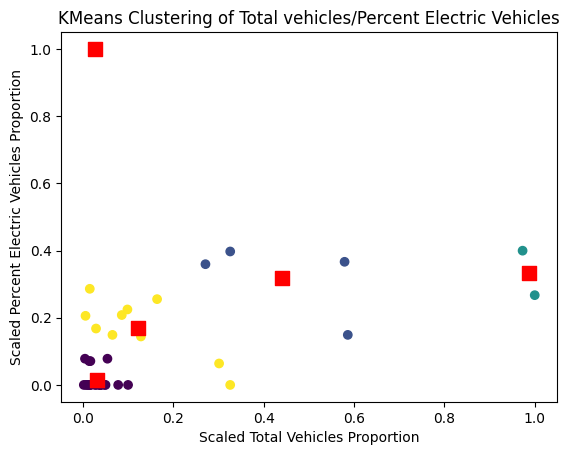

In [ ]:
from sklearn.cluster import KMeans

max_value = cars_list_KMeans[4]['Percent Electric Vehicles'].max()
scale_factor = 1 / max_value if max_value != 0 else 1
cars_list_KMeans[4]['Scaled Percent Electric Vehicles'] = cars_list_KMeans[4]['Percent Electric Vehicles'] * scale_factor
max_value = cars_list_KMeans[4]['Total Vehicles'].max()
scale_factor = 1 / max_value if max_value != 0 else 1
cars_list_KMeans[4]['Scaled Total Vehicles'] = cars_list_KMeans[4]['Total Vehicles'] * scale_factor

kmeans = KMeans(n_clusters = 5).fit(cars_list_KMeans[4][['Scaled Total Vehicles', 'Scaled Percent Electric Vehicles']])

plt.scatter(cars_list_KMeans[4]['Scaled Total Vehicles'], cars_list_KMeans[4]['Scaled Percent Electric Vehicles'], c=kmeans.labels_.astype(float), cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='s', c='red', s=100)
plt.title('KMeans Clustering of Total vehicles/Percent Electric Vehicles')
plt.xlabel('Scaled Total Vehicles Proportion')
plt.ylabel('Scaled Percent Electric Vehicles Proportion')

In [ ]:
cars_list_KMeans[4].head()

,level_0,index,Date,County,State,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,Scaled Percent Electric Vehicles,Scaled Total Vehicles
1,2377,15410,2021-12-31,Adams,WA,5417,5417,0.00,0.000000,0.009646
11,2217,14354,2021-12-31,Asotin,WA,6752,6752,0.00,0.000000,0.012023
14,1445,9436,2021-12-31,Benton,WA,43699,43699,0.00,0.000000,0.077816
31,888,5768,2021-12-31,Chelan,WA,54669,55191,0.95,0.224586,0.098280
34,266,1792,2021-12-31,Clallam,WA,22110,22111,0.00,0.000000,0.039374


Scratch code of K-means

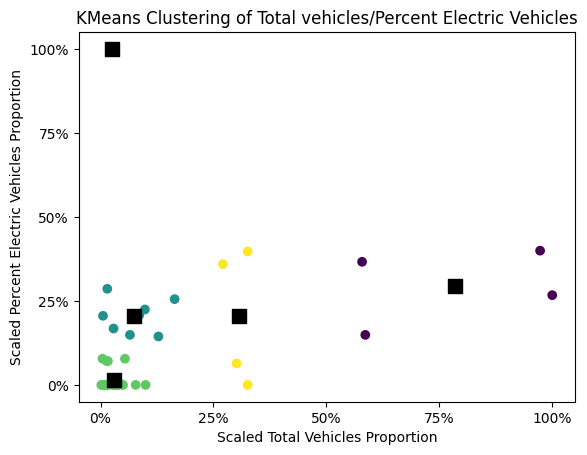

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

x = cars_list_KMeans[4][['Scaled Total Vehicles', 'Scaled Percent Electric Vehicles']].to_numpy()
centroids = x[np.random.choice(x.shape[0], 5, replace=False)]
#set max iterations 100
for i in range(0,100):
  distances = np.linalg.norm(x[:, np.newaxis] - centroids, axis=2)
  labels = np.argmin(distances, axis=1)
  new_centroids = np.array([x[labels == k].mean(axis=0) for k in range(0,5)])
  if np.allclose(centroids, new_centroids):
    break
  centroids = new_centroids
distances = np.linalg.norm(x[:, np.newaxis] - centroids, axis=2)
predict = np.argmin(distances, axis=1)

plt.scatter(x[:, 0], x[:, 1], c=predict, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='s', color='black', s=100)
plt.title('KMeans Clustering of Total vehicles/Percent Electric Vehicles')
plt.xlabel('Scaled Total Vehicles Proportion')
plt.ylabel('Scaled Percent Electric Vehicles Proportion')
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.show()

In [ ]:
merged_all_state_percent_emission_2017_2021 = merged_all_state_percent_emission.copy(deep=True)
x = merged_all_state_percent_emission_2017_2021["Percent Electric Vehicles"]
y = merged_all_state_percent_emission_2017_2021["year"]
merged_all_state_percent_emission_2017_2021.head(2000)

,State,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,year,index,sector-name,fuel-name,Carbon Dioxide Emissions From Transportation,Weighted Electric Vehicles,Weighted Percent Electric Vehicles
0,AK,46,47,2.127660,2017,54511,Transportation carbon dioxide emissions,All Fuels,11.233929,100.0,0.000636
1,AZ,2398,2406,0.332502,2017,54540,Transportation carbon dioxide emissions,All Fuels,36.870866,800.0,0.005084
2,CA,7736,7776,0.514403,2017,54578,Transportation carbon dioxide emissions,All Fuels,208.002702,4000.0,0.025420
3,CO,777,780,0.384615,2017,54597,Transportation carbon dioxide emissions,All Fuels,29.494230,300.0,0.001907
4,CT,299,301,0.664452,2017,54623,Transportation carbon dioxide emissions,All Fuels,15.414134,200.0,0.001271
...,...,...,...,...,...,...,...,...,...,...,...
164,PA,151,158,4.430380,2021,59618,Transportation carbon dioxide emissions,All Fuels,55.979143,700.0,0.004449
165,SC,380,388,2.061856,2021,59662,Transportation carbon dioxide emissions,All Fuels,32.613895,800.0,0.005084
166,TN,220,223,1.345291,2021,59704,Transportation carbon dioxide emissions,All Fuels,45.725218,300.0,0.001907
167,TX,2096,2126,1.411101,2021,59723,Transportation carbon dioxide emissions,All Fuels,215.203405,3000.0,0.019065


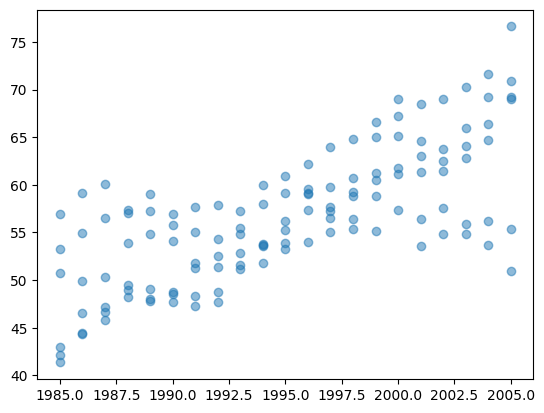

In [ ]:
emissions_logic_test= emissions_backup[(emissions_backup['state-name'] == "Ohio") | \
                                       (emissions_backup['state-name'] == "Georgia") | \
                                       (emissions_backup['state-name'] == "Pennsylania") | \
                                       (emissions_backup['state-name'] == "Louisiana") | \
                                       (emissions_backup['state-name'] == "Michigan") | \
                                       (emissions_backup['state-name'] == "New Jersey") | \
                                       (emissions_backup['state-name'] == "Illinois") ]
emissions_logic_test = emissions_logic_test[emissions_logic_test["year"] >= 1985]
emissions_logic_test = emissions_logic_test[emissions_logic_test["year"] <= 2005]
plt.scatter(emissions_logic_test["year"], emissions_logic_test["value"], alpha=0.5)

In [ ]:
emissions_logic_test.head(200)

,year,state-name,sector-name,fuel-name,value
17899,1985,Georgia,Transportation carbon dioxide emissions,All Fuels,42.092763
17961,1985,Illinois,Transportation carbon dioxide emissions,All Fuels,50.708595
18074,1985,Louisiana,Transportation carbon dioxide emissions,All Fuels,41.349361
18164,1985,Michigan,Transportation carbon dioxide emissions,All Fuels,42.980472
18347,1985,New Jersey,Transportation carbon dioxide emissions,All Fuels,56.952582
...,...,...,...,...,...
41387,2005,Illinois,Transportation carbon dioxide emissions,All Fuels,76.635610
41498,2005,Louisiana,Transportation carbon dioxide emissions,All Fuels,50.934588
41590,2005,Michigan,Transportation carbon dioxide emissions,All Fuels,55.405086
41771,2005,New Jersey,Transportation carbon dioxide emissions,All Fuels,69.209090


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

emissions_logic_test['year_category'] = emissions_logic_test['year'].apply(lambda x: 0 if x < 1995 else 1)
x = emissions_logic_test[['value']]
y = emissions_logic_test['year_category']
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=12)

logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
y_pred = logistic_model.predict(x_test)
logistic_model.predict_proba(x_test)

array([[1.20398667e-04, 9.99879601e-01],
       [4.81418643e-02, 9.51858136e-01],
       [2.55979775e-01, 7.44020225e-01],
       [1.72500180e-01, 8.27499820e-01],
       [2.36533590e-01, 7.63466410e-01],
       [1.54427588e-01, 8.45572412e-01],
       [3.25279470e-01, 6.74720530e-01],
       [5.06772025e-01, 4.93227975e-01],
       [2.21075190e-01, 7.78924810e-01],
       [2.46528087e-01, 7.53471913e-01],
       [2.32728720e-03, 9.97672713e-01],
       [6.90536175e-02, 9.30946382e-01],
       [5.23390361e-01, 4.76609639e-01],
       [4.42962536e-01, 5.57037464e-01],
       [6.05597929e-01, 3.94402071e-01],
       [7.60994918e-01, 2.39005082e-01],
       [7.71684337e-01, 2.28315663e-01],
       [9.40481372e-01, 5.95186282e-02],
       [1.29966200e-02, 9.87003380e-01],
       [2.11243179e-01, 7.88756821e-01],
       [9.86417803e-02, 9.01358220e-01],
       [2.50907205e-01, 7.49092795e-01],
       [5.66048323e-02, 9.43395168e-01],
       [3.78878468e-01, 6.21121532e-01],
       [8.728692

Text(0.5, 1.0, 'Logistic Regression Curve before year 1995 or not')

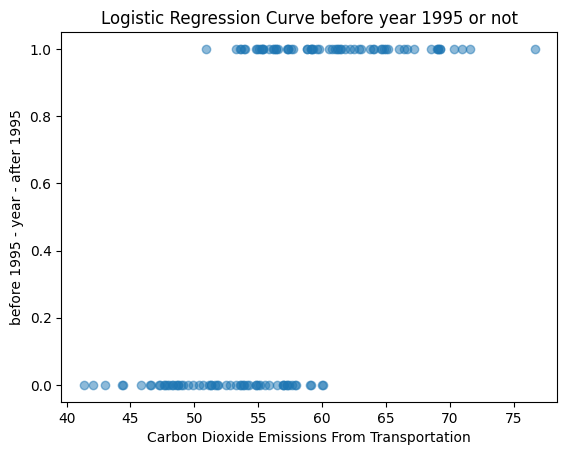

In [ ]:
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Carbon Dioxide Emissions From Transportation')
plt.ylabel('before 1995 - year - after 1995')
plt.title('Logistic Regression Curve before year 1995 or not')

In [ ]:
logistic_model.score(x_test, y_test)

0.7456140350877193

In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1])

In [ ]:
x_test

,value
41387,76.635610
20687,60.069405
27741,54.811025
40425,56.185182
25497,55.098475
...,...
39440,62.845204
27467,51.165150
34500,55.188647
39555,70.316855



You can use sklearn, scipy, etc libraries to import your ML models and use them as part of your assignment aside from your ML models from scratch.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


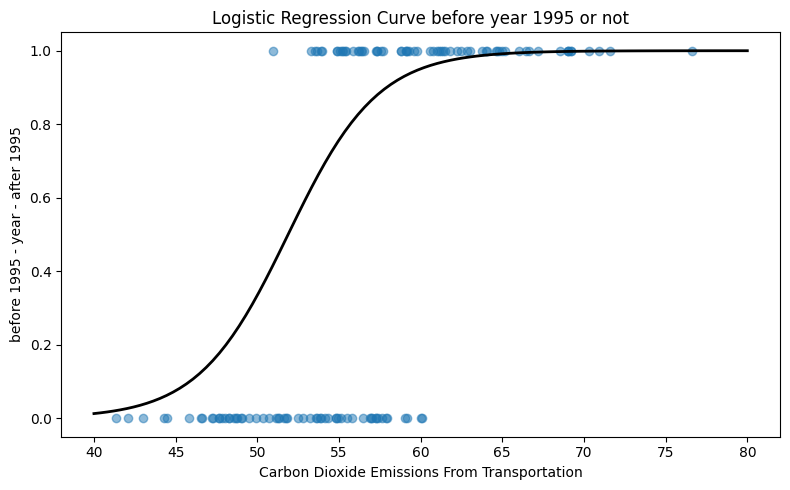

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.5)
x = np.linspace(40, 80, 100).reshape(-1,1)
y = logistic_model.predict_proba(x)[:,1]
plt.plot(x, y, color='black', linewidth=2)
plt.xlabel('Carbon Dioxide Emissions From Transportation')
plt.ylabel('before 1995 - year - after 1995')
plt.title('Logistic Regression Curve before year 1995 or not')

plt.tight_layout()
plt.show()

In [ ]:
logistic_model.predict_proba(x)[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0.01295313, 0.01497832, 0.01731458, 0.02000785, 0.02311019,
       0.02668048, 0.03078496, 0.03549784, 0.04090177, 0.04708818,
       0.05415746, 0.06221875, 0.07138938, 0.0817938 , 0.09356181,
       0.10682595, 0.12171802, 0.13836451, 0.15688097, 0.1773653 ,
       0.19989018, 0.22449502, 0.25117772, 0.27988724, 0.3105175 ,
       0.34290366, 0.37682155, 0.41199089, 0.44808249, 0.48472942,
       0.52154131, 0.55812072, 0.59408015, 0.62905817, 0.66273325,
       0.69483427, 0.72514707, 0.75351695, 0.77984755, 0.80409667,
       0.82626984, 0.84641272, 0.86460286, 0.88094168, 0.89554704,
       0.9085467 , 0.92007289, 0.9302579 , 0.93923077, 0.94711484,
       0.95402612, 0.96007227, 0.96535216, 0.9699557 , 0.97396408,
       0.97745012, 0.98047875, 0.98310764, 0.98538778, 0.9873641 ,
       0.98907609, 0.99055834, 0.99184113, 0.99295087, 0.99391059,
       0.99474035, 0.99545755, 0.99607735, 0.99661286, 0.99707548,
       0.99747508, 0.99782019, 0.99811823, 0.99837558, 0.99859

I wrote the underlying logistic regression algorithm but it didn't work well so I deleted it.

And I just found out that I can use the sklearn library to write this assignment.

That's all for Assignment 2.